In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
words = open('names.txt', 'r').read().splitlines()

In [5]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
vocab_size

27

In [8]:
# dataset generation with splits

def build_dataset(words):

    X, Y = [], []
    for w in words:
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
block_size = 3

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182437, 3]) torch.Size([182437])
torch.Size([22781, 3]) torch.Size([22781])
torch.Size([22928, 3]) torch.Size([22928])


In [61]:
## MLP Structure

n_embed = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed),             generator = g)
W1 = torch.randn((n_embed * block_size, n_hidden), generator = g) * ((5/3) / ((n_embed * block_size)**0.5)) # multiply by gain/sqrt(fan_in)
b1 = torch.randn(n_hidden,                         generator = g) * 0.01 
W2 = torch.randn((n_hidden, vocab_size),           generator = g) * 0.01
b2 = torch.randn(vocab_size,                       generator = g) * 0

bngain = torch.ones([1, n_hidden])
bnbias = torch.zeros([1, n_hidden])

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
for p in parameters:
    p.requires_grad = True

sum(p.nelement() for p in parameters)

12297

In [62]:
# with batches and train dataset with bigger MLP and embedding space
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    #mini batch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    #forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1 #hidden layer pre activation
    hpreact = bngain * ((hpreact - hpreact.mean(0, keepdim=True))/hpreact.std(0, keepdim=True)) + bnbias # batch normalization
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    #track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps: 7d} : {loss.item():.4f}')
    lossi.append(loss.log10().item())
    #break

      0/ 200000 : 3.3054
  10000/ 200000 : 1.7978
  20000/ 200000 : 1.9030
  30000/ 200000 : 2.4623
  40000/ 200000 : 2.4436
  50000/ 200000 : 1.8843
  60000/ 200000 : 2.4164
  70000/ 200000 : 2.1734
  80000/ 200000 : 1.7217
  90000/ 200000 : 2.3225
 100000/ 200000 : 2.2514
 110000/ 200000 : 2.1481
 120000/ 200000 : 1.9692
 130000/ 200000 : 1.7992
 140000/ 200000 : 2.2786
 150000/ 200000 : 2.1926
 160000/ 200000 : 1.9286
 170000/ 200000 : 2.1592
 180000/ 200000 : 2.5601
 190000/ 200000 : 1.7961


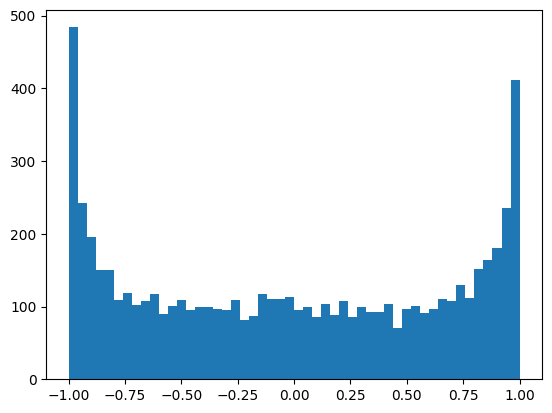

In [63]:
# visualize h during initialization
plt.hist(h.view(-1).tolist(), 50);

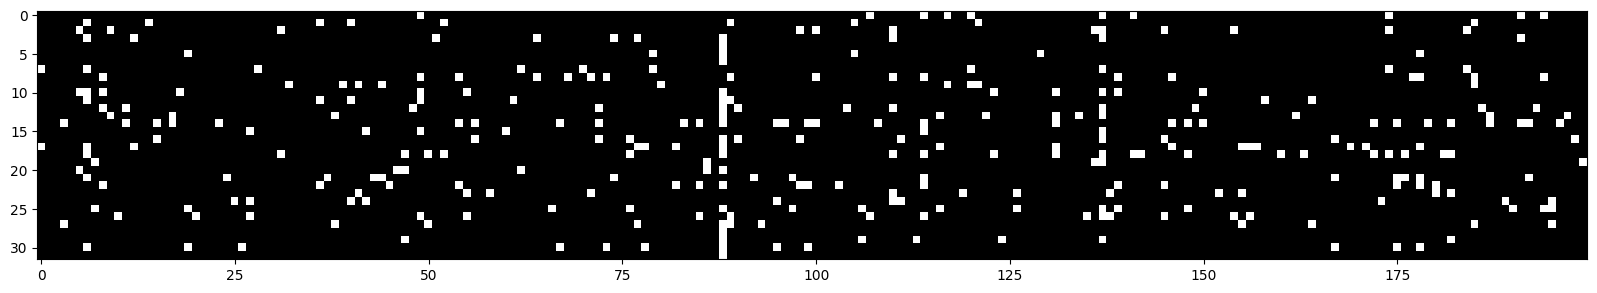

In [64]:
plt.figure(figsize = (20,10))
plt.imshow(h.abs() > 0.99, cmap = 'gray', interpolation='nearest')

In [68]:
# Calubrate the batch norm at the end of training
with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    #measure mean and std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [69]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val' : (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1 #hidden layer pre activation
    hpreact = bngain * ((hpreact - bnmean)/bnstd) + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
split_loss('train')
split_loss('val')

train 2.0649521350860596
val 2.125127077102661


In [16]:
#sampling from the model
g = torch.Generator().manual_seed(2147483647)

for i in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        if ix == 0:
            break
        out.append(ix)
    print(''.join(itos[i] for i in out))

cex
mariah
mikilah
tyhamellissana
nella
kamandr
samiyah
javariilah
michimerkingse
ted
jenter
masidgu
tiaviyng
fobse
huniten
tahlan
kasdri
anwil
pyan
isan


In [104]:
# Lets train a deeper network

class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        #parameters
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        #buffers
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        #calculate the foreward pass
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = ( x - xmean ) / (torch.sqrt(xvar + self.eps))
        self.out = self.gamma * xhat + self.beta
        #update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embed),             generator = g)
layers = [
    Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size), BatchNorm1d(vocab_size),
]

with torch.no_grad():
    # last layer make less confident
    #layers[-1].weight *= 0.1
    layers[-1].gamma *= 0.1
    #all other layers apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3 #the std deviation of weights will eventually shrink to zero if gain is not 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

47551


In [109]:
# training
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

    #mini batch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    #forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)
    
    #backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    #track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps: 7d} : {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])

      0/ 200000 : 2.2772
  10000/ 200000 : 2.1336
  20000/ 200000 : 2.1609
  30000/ 200000 : 2.3562
  40000/ 200000 : 2.0715
  50000/ 200000 : 2.1270
  60000/ 200000 : 2.2873
  70000/ 200000 : 2.1356
  80000/ 200000 : 2.1643
  90000/ 200000 : 2.4044
 100000/ 200000 : 2.0669
 110000/ 200000 : 1.6299
 120000/ 200000 : 2.0833
 130000/ 200000 : 2.2096
 140000/ 200000 : 2.2475
 150000/ 200000 : 2.2937
 160000/ 200000 : 2.4193
 170000/ 200000 : 2.1924
 180000/ 200000 : 2.2525
 190000/ 200000 : 1.7320


layer 2 ( Tanh): mean -0.00, std 0.63, saturated: 2.97%
layer 5 ( Tanh): mean -0.00, std 0.64, saturated: 2.59%
layer 8 ( Tanh): mean -0.00, std 0.64, saturated: 2.19%
layer 11 ( Tanh): mean +0.00, std 0.65, saturated: 2.12%
layer 14 ( Tanh): mean -0.00, std 0.65, saturated: 1.66%


Text(0.5, 1.0, 'activation distribution')

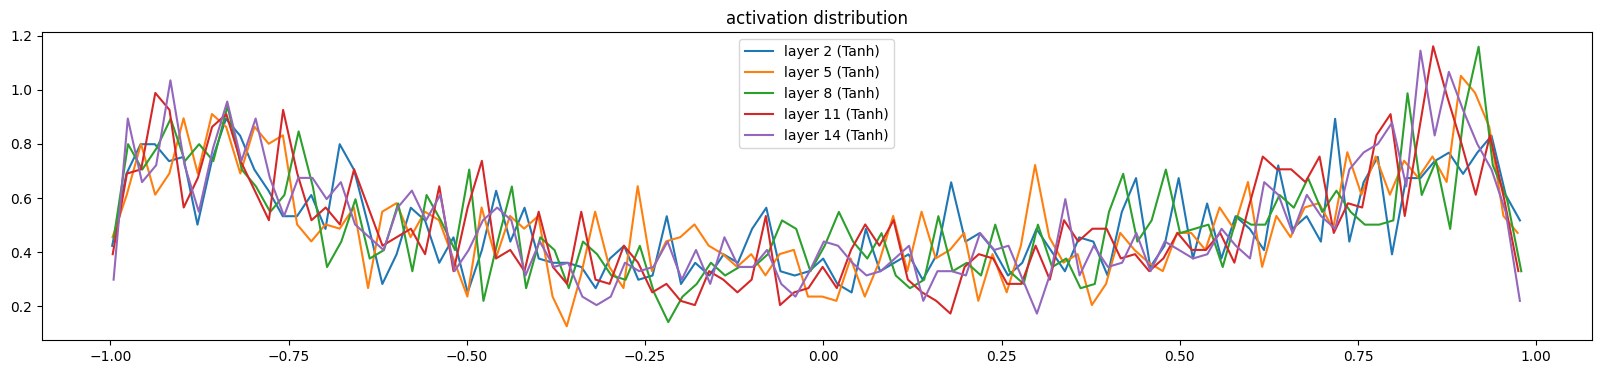

In [106]:
# visualize histograms 
plt.figure(figsize=(20, 4)) # width and height of the plot 
legends = [] 
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer 
    if isinstance(layer, Tanh): 
        t = layer.out
        print('layer %d (%5s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends) ; 
plt.title('activation distribution')


layer 2 ( Tanh): mean +0.00, std 2.985767e-03
layer 5 ( Tanh): mean +0.00, std 2.543701e-03
layer 8 ( Tanh): mean -0.00, std 2.470582e-03
layer 11 ( Tanh): mean +0.00, std 2.311887e-03
layer 14 ( Tanh): mean +0.00, std 2.358912e-03


Text(0.5, 1.0, 'gradient distribution')

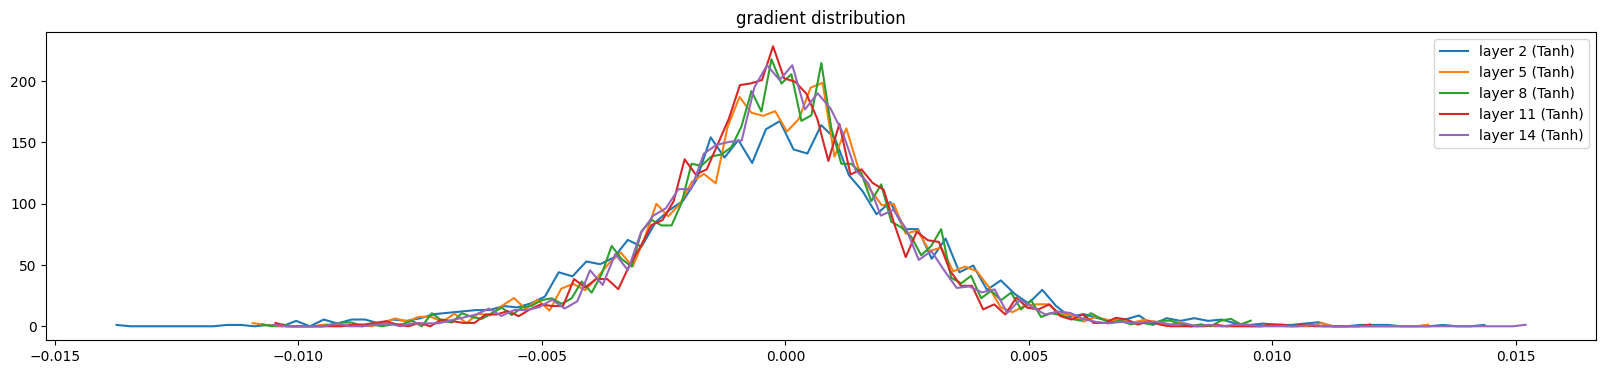

In [107]:
# visualize histograms 
plt.figure(figsize=(20, 4)) # width and height of the plot 
legends = [] 
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer 
    if isinstance(layer, Tanh): 
        t = layer.out.grad
        print('layer %d (%5s): mean %+.2f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends) ; 
plt.title('gradient distribution')

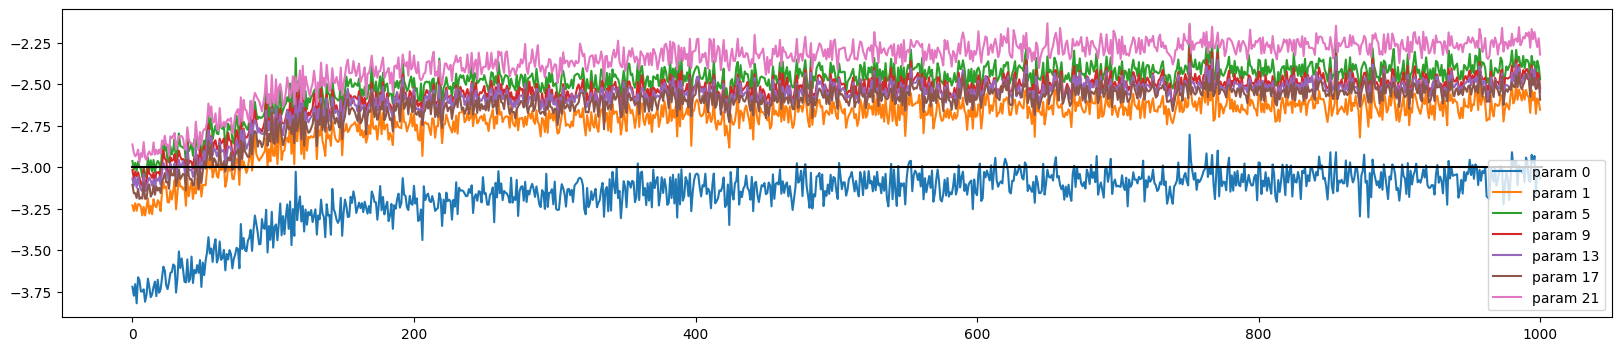

In [108]:
plt.figure(figsize=(20, 4)) # width and height of the plot 
legends = [] 
for i, p in enumerate(parameters): # note: exclude the output layer 
    if p.ndim == 2: 
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k')  
plt.legend(legends)

In [110]:
@torch.no_grad()
def split_loss(split):
    X, y = {
        'train': (Xtr, Ytr),
        'val' : (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[X]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())
split_loss('train')
split_loss('val')

train 2.0090909004211426
val 2.0982301235198975
